<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/pybfs/blob/main/PyBFS_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import math
from google.colab import files

# **Upload/Load Data**

In [ ]:
uploaded = files.upload()

Saving 2312200_data.csv to 2312200_data.csv


In [ ]:
streamflow_data = pd.read_csv('2312200_data.csv')

In [ ]:
data = streamflow_data['Streamflow']

In [ ]:
uploaded = files.upload()

Saving bfs_params_50.csv to bfs_params_50.csv


In [ ]:
bfs_params_usgs = pd.read_csv('bfs_params_50.csv')

** PyBFS Functions**

In [ ]:
def sur_z(lb, a, ws, por, ss): #calculates saturated thickness of the surface reservoir ,zs
    a1 = 1 / (2*a)
    b1 = -2 * ws
    c1 = ss / (lb * por)

    discriminant = b1 ** 2 - 4 * a1 * c1

    if discriminant < 0:
        return ws * a
    else:
        return (-b1 - math.sqrt(discriminant)) / (2 * a1)

def sur_store(lb, a, ws, por, zs):  #calculates surface storag, ss
    z = min(ws * a, zs)
    result = lb * (2 * ws * zs - zs**2 / a) * por
    return result

def sur_q(lb, a, ks, z): #calculates the surface discharge  from reservoirQs
    return 2 * lb * z * a * ks

def dir_q(lb, a, z, i): #calculates the direct runoff Qd from the surface reservoir
    return 2 * lb * z / a * i

def infiltration(lb, ws, ks, a, zs, i): #calculates the infiltration I
    return 2 * lb * (ws - zs / a) * min(i, ks)

def recharge(lb, xb, ws, kz, zs, por): #calculates recharge R
    return (lb - xb) * 2 * ws * min(zs * por, kz)

In [ ]:
def get_values_for_site(df, site_no):  # Searches dataframe of different site parameters to fetch particular site no
    # Define the column groups
    basin_char_columns = ["AREA", "Lb", "X1", "Wb", "POR"]
    gw_hyd_columns = ["ALPHA", "BETA", "Ks", "Kb", "Kz"]
    flow_columns = ["Qthresh", "Rs", "Rb1", "Rb2", "Prec", "Frac4Rise"]

    # Initialize the dictionaries
    basin_char_dict = {}
    gw_hyd_dict= {}
    flow_dict = {}

    # Iterate over the rows of the dataframe
    for idx, row in df.iterrows():
        site_no_key = row['site_no']

        # Assign the respective columns to the dictionaries
        basin_char_dict[site_no_key] = list(row[basin_char_columns].values)
        gw_hyd_dict[site_no_key] = list(row[gw_hyd_columns].values)
        flow_dict[site_no_key] = list(row[flow_columns].values)

    # Get the values for the specific site number
    basin_char = basin_char_dict.get(site_no)
    gw_hyd = gw_hyd_dict.get(site_no)
    flow = flow_dict.get(site_no)

    return basin_char, gw_hyd, flow

In [ ]:
basin_char, gw_hyd, flow = get_values_for_site(bfs_params_usgs, 2312200)

# **PyBT**

In [ ]:
  #basin characteristics
  area, lb, x1, wb, por, ws = basin_char[0], basin_char[1], basin_char[2], basin_char[3], basin_char[4], basin_char[3] / 2

  # Groundwater hydraulic parameters
  alpha, beta, ks, kb, kz = gw_hyd[0], gw_hyd[1], gw_hyd[2], gw_hyd[3], gw_hyd[4]

  # Flow metrics
  qthresh, rs, rb1, rb2, prec, fr4rise = flow[0], flow[1], flow[2], flow[3], flow[4], flow[5]

In [ ]:
def base_table(lb, x1, wb, b, kb, q, por):

    qin = np.array(q['Streamflow'])
    # Remove NaNs and extract positive flow values
    tmp_q = qin[~np.isnan(qin)]
    tmp_q = tmp_q[tmp_q > 0]

    # Define the log range of flow values
    tmp_range = np.log10([np.min(tmp_q) / 10, np.max(tmp_q)])

    # Create log-spaced discharge values
    qq = np.logspace(tmp_range[0], tmp_range[1], num=1000)
    qq[0] = 0

    # Calculate z based on the value of b
    if b != 0.5:
        z = ((qq * x1 * (2 * b - 1)) / (wb * kb * b ** 2)) ** (b / (2 * b - 1))
    else:
        z = np.exp(qq * 2 * x1 / (wb * kb))

    # Compute x and storage s
    x = x1 * z ** (1 / b)
    s = wb * por * ((1 / x1 ** b) * (1 / (b + 1)) * x ** (b + 1) + (lb - x) * z)

    # Construct the table and round values
    BT = pd.DataFrame({
        'Xb': np.round(x, 5),
        'Z':  np.round(z, 5),
        'S':  np.round(s, 5),
        'Q':  np.round(qq, 5)
    })

    # Filter out rows where x < lb
    BT = BT[BT['Xb'] < lb]

    return BT

In [ ]:
SBT = base_table(lb, x1, wb, beta, kb, streamflow_data, por)
SBT

Xb         Z             S             Q
0       0.00000   0.00000  0.000000e+00  0.000000e+00
1       0.02813   0.00055  6.676426e+02  9.389791e+01
2       0.02848   0.00055  6.751460e+02  9.483536e+01
3       0.02883   0.00056  6.827338e+02  9.578217e+01
4       0.02920   0.00056  6.904069e+02  9.673844e+01
..          ...       ...           ...           ...
995  6453.06905  36.42164  3.754746e+07  1.824576e+06
996  6533.70170  36.83097  3.788062e+07  1.842793e+06
997  6615.34188  37.24490  3.821540e+07  1.861191e+06
998  6698.00217  37.66349  3.855177e+07  1.879772e+06
999  6781.69533  38.08678  3.888970e+07  1.898540e+06

[1000 rows x 4 columns]

# **PyBFS**

In [ ]:
def PyBFS(streamflow, SBT, basin_char, gw_hyd, flow):
  """
  SBT : pd.DataFrame
        Baseflow table with columns ['Xb','Z','S','Q'].
        """
  date = pd.to_datetime(streamflow["Date"])
  qin = np.array(streamflow['Streamflow'])
  qmean = np.nanmean(qin)

  timestep = 'day'
  error_basis = 'total'

  # Error tolerance used sequentially to refine impulse
  ifact = [2, 1.1]
  # Number of time steps
  p = len(qin)

  # calculates the change in streamflow (dq) between consecutive time steps. This change helps identify recessional periods (when streamflow is decreasing).
  dq = np.zeros(p)
  if timestep == 'day':
      dq[1:] = qin[1:] - qin[:-1]
  elif timestep == 'hour':
      for y in range(24, p):
          dq[y] = qin[y] - np.nanmax(qin[(y-24):y])

  #basin characteristics
  area, lb, x1, wb, por, ws = basin_char[0], basin_char[1], basin_char[2], basin_char[3], basin_char[4], basin_char[3] / 2

  # Groundwater hydraulic parameters
  alpha, beta, ks, kb, kz = gw_hyd[0], gw_hyd[1], gw_hyd[2], gw_hyd[3], gw_hyd[4]

  # Flow metrics
  qthresh, rs, rb1, rb2, prec, fr4rise = flow[0], flow[1], flow[2], flow[3], flow[4], flow[5]

  #dqfr represents the fractional change in streamflow. #It's used to determine the nature of the change in streamflow relative to the current flow.
  dqfr = dq / qin
  dqfr[(dq == 0) & (qin == 0)] = 0
  dqfr[(dq < 0) & (qin == 0)] = 1

  rise = (dqfr > fr4rise) & (dq > prec)
  rise[np.isnan(rise)] = False

  recess = (dqfr <= fr4rise) | (dq < prec)
  recess[np.isnan(recess)] = False

  #recess_day: An array counting the number of consecutive recession periods up to each time step
  recess_day = np.cumsum(recess) - np.maximum.accumulate((~recess).astype(int) * np.cumsum(recess))

  # Output variables
  X = np.full(p, np.nan)  #LONGITUDINAL LOCATION OF BASE WATER LEVEL INTERSECTION WITH SURFACE, xb
  qcomp = np.full((p, 3), np.nan) ##THREE FLOW COMPONENTS: surface flow; base flow; direct runoff from saturated areas
  ETA = np.full(p, np.nan)  #STATE DISTURBANCES (POSITIVE VALUES REPRESENT INPUTS)
  I = np.full(p, np.nan) #PRECIPITATION CALCULATED FROM eta
  Z = np.full((p, 2), np.nan) #WATER SURFACE ELEVATION OF SURFACE (CHANNEL IS DATUM) AND BASE (BASIN OUTLET IS DATUM), ZS and Zb
  ST = np.full((p, 2), np.nan) #STORAGE, surface and base
  EXC = np.full((p, 2), np.nan) #EXCHANGES, INFILTRATION AND RECHARGE


  #CHECK PARAMETERS, END PROCESS IF PARAMETERS ARE BAD
  if np.any(np.array([lb, x1, wb, alpha, beta, ks, kb, ks, por, qthresh, -rs, -rb1, -rb2, prec, fr4rise]) < 0):
      ts = 10 * p # 10 * p is considered invalid
      print('Negative parameter(s)')
  if lb * wb > area:
      ts = 10 * p
      print('lb x wb > area')
  if np.any(np.isnan(SBT)):
      ts = 10 * p
      print('Cannot calculate discharge for base parameters')

  #basin characteristics
  area, lb, x1, wb, por, ws = basin_char[0], basin_char[1], basin_char[2], basin_char[3], basin_char[4], basin_char[3] / 2

  # Groundwater hydraulic parameters
  alpha, beta, ks, kb, kz = gw_hyd[0], gw_hyd[1], gw_hyd[2], gw_hyd[3], gw_hyd[4]

  # Flow metrics
  qthresh, rs, rb1, rb2, prec, fr4rise = flow[0], flow[1], flow[2], flow[3], flow[4], flow[5]

  ts = 0  #INITIAL TIME STEP
  stts = ts  #STARTING TIME STEP, stts, FOR ERROR CALCULATION


  #This code iterates through the qin array starting from a time step ts, skipping over any NaN values.
  #When it finds the first valid (non-NaN) value, it stores that time step in the variable sttts.
  while np.isnan(qin[ts]):
      ts += 1
      stts = ts #
  # Initialize Variables
  ts_ini = True
  # Initialize variables
  qb_in = min(qin[ts], qmean)
  qb_en = np.nan
  idx = (SBT["Q"] <= qb_in).sum()

  # Adjust for zero-based indexing and avoid out-of-bounds errors
  xb_in = SBT["Xb"].iloc[idx - 1] if idx > 0 else np.nan
  zb_in = SBT["Z"].iloc[idx - 1] if idx > 0 else np.nan
  sb_in = SBT["S"].iloc[idx - 1] if idx > 0 else np.nan

  # Calculate available base storage
  sba = np.max(SBT['S']) - sb_in

  # Surface flow and other calculations
  qs_in = max(0, qin[ts] - qb_in)  # Ensure surface flow is non-negative
  zs_in = min(qs_in / (2 * lb * ks * alpha), ws * alpha)  # Saturated thickness of surface reservoir
  ss_in = sur_store(lb, alpha, ws, por, zs_in)  # Surface storage
  ssa = sur_store(lb, alpha, ws, por, ws * alpha) - ss_in  # AVAILABLE SURFACE STORAGE

  # Infiltration and recharge
  infil_in = 0
  rech_in = recharge(lb, xb_in, ws, kz, zs_in, por)

  while ts < p:

      # Initialize Time Step Using State Variables for Previous Time Step if Available
      if not ts_ini:
          xb_in = X[ts - 1]
          zb_in = Z[ts - 1, 1]
          sb_in = ST[ts - 1, 1]

          idx = (SBT["Xb"] <= xb_in).sum()
          qb_in = SBT["Q"].iloc[idx - 1] if idx > 0 else np.nan

          zs_in = Z[ts - 1, 0]
          ss_in = ST[ts - 1, 0]
          qs_in = sur_q(lb, alpha, ks, zs_in)

          # Storage Capacity Available
          ssa = sur_store(lb, alpha, ws, por, ws * alpha) - ss_in
          sba = max(SBT['S']) - sb_in
          rech_in = min(recharge(lb, xb_in, ws, kz, zs_in, por), sba + qb_in)
          qd = 0
          infil_in = 0

          # Impulse (PPT) Needed to Generate Observed Streamflow
          I[ts] = 0  # Set Impulse to Zero
          etaest = max(0, qin[ts] - qb_in - qs_in)

          # Initial Estimate of Impulse Required for Additional Surface Flow
          if ts > 1 and etaest > 0:
              if rise[ts] or rise[ts - 1]:
                  I[ts] = etaest / (2 * lb * ws)
                  zs = zs_in
                  qs = qs_in

                  # Loop to Calculate Additional Impulse Needed to Reduce ETA
                  # Use Progressively Smaller Incremental Changes in Impulse (ifact) for Iterations
                  for x in ifact:
                      i = I[ts]
                      eta = etaest
                      while eta > max(prec, qin[ts] / 100) and i > 0:
                          I[ts] = i
                          etaest = eta
                          i = x * i
                          infil = min(infiltration(lb, ws, ks, alpha, (zs_in + zs) / 2, i), ssa)  # Limit Infiltration to Available Storage
                          ss = max(ss_in + infil - rech_in - qs, 0)  # Update Surface Storage
                          zs = sur_z(lb, alpha, ws, por, ss)
                          qs = sur_q(lb, alpha, ks, zs)
                          qd = dir_q(lb, alpha, zs_in, i) + dir_q(lb, alpha, (zs - zs_in), i / 2) + max(2 * lb * (ws - zs_in / alpha) * (I[ts] - ks), 0)
                          eta = qin[ts] - qs - qd - qb_in

          infil_in = min(infiltration(lb, ws, ks, alpha, zs_in, I[ts]), ssa)  # Close Initial Calculations When Streamflow Record is Available (Not Projection)

      # End of Time Step Calculations
      ss_en = max(ss_in + infil_in - rech_in - qs_in, 0)
      zs_en = sur_z(lb, alpha, ws, por, ss_en)
      qs_en = sur_q(lb, alpha, ks, zs_en)
      infil_en = min(infiltration(lb, ws, ks, alpha, zs_en, I[ts]), ssa)
      rech_en = min(recharge(lb, xb_in, ws, kz, zs_en, por), sba + qb_in)
      sb_en = max(sb_in + rech_en - qb_in, 0)
      idx = max((SBT["S"] < sb_en).sum(), 1) - 1

      # Safely extract the values from the DataFrame
      xb_en = SBT["Xb"].iloc[idx] if 0 <= idx < len(SBT) else np.nan
      zb_en = SBT["Z"].iloc[idx] if 0 <= idx < len(SBT) else np.nan
      qb_en = SBT["Q"].iloc[idx] if 0 <= idx < len(SBT) else np.nan

      # Final Calculations for Time Step
      qcomp[ts, 0] = (qs_in + qs_en) / 2  # Surface Flow
      qcomp[ts, 1] = (qb_in + qb_en) / 2  # Base Flow

      EXC[ts, 0] = (infil_in + infil_en) / 2
      EXC[ts, 1] = (rech_in + rech_en) / 2

      # For Initial Time Step
      if ts_ini:
          ST[ts, :] = [ss_en, sb_en]
          Z[ts, :] = [zs_en, zb_en]

      # For Time Steps When States Are Available for Previous Time Step
      if not ts_ini:
          ST[ts, 0] = max(ST[ts - 1, 0] + EXC[ts, 0] - qcomp[ts, 0] - EXC[ts, 1], 0)
          ST[ts, 0] = min(ST[ts, 0], sur_store(lb, alpha, ws, por, ws * alpha))
          Z[ts, 0] = sur_z(lb, alpha, ws, por, ST[ts, 0])
          ST[ts, 1] = max(ST[ts - 1, 1] + EXC[ts, 1] - qcomp[ts, 1], 0)
          ST[ts, 1] = min(ST[ts, 1], max(SBT['S']))

          idx = max((SBT['S'] <= ST[ts, 1]).sum(), 1) - 1
          Z[ts, 1] = SBT['Z'].iloc[idx] if 0 <= idx < len(SBT) else np.nan

          # Direct Runoff includes additional saturated area x half of rainfall (excess after infiltration), and any precipitation that exceeds infiltration rate
          qcomp[ts, 2] = dir_q(lb, alpha, zs_in, I[ts]) + dir_q(lb, alpha, (Z[ts, 0] - zs_in), I[ts] / 2) + max(2 * lb * (ws - zs_in / alpha) * (I[ts] - ks), 0)

      ETA[ts] = qin[ts] - np.sum(qcomp[ts, 0:3])  # Streamflow Residual
      idx = max((SBT['S'] <= ST[ts, 1]).sum(), 1) - 1
      X[ts] = SBT['Xb'].iloc[idx] if 0 <= idx < len(SBT) else np.nan

      ts += 1
      ts_ini = False
      #CLOSE CONDITION ts<p

  if error_basis == 'base':
      q4er = qcomp[:, 1]
  elif error_basis == 'total':
      q4er = np.sum(qcomp, axis=1)

  # ADJUSTED PERCENT ERROR
  APE = (q4er - qin) / (qin + prec)
  APE[(qin == 0) & (q4er == 0)] = 0

  # WEIGHT VARIES FROM 0 TO 1 WITH INCREASING LENGTH OF RECESSION
  Weight = 1 - np.exp(rs * recess_day)

  # WEIGHT OF 1 IS ASSIGNED TO OVER PREDICTION
  Weight[APE > 0] = 1

  tmp = pd.DataFrame({'Date': date, 'Qob': qin, 'Qsim': np.sum(qcomp, axis=1), 'SurfaceFlow': qcomp[:, 0], 'Baseflow': qcomp[:, 1], 'DirectRunoff': qcomp[:, 2], 'X': X,'Eta': ETA, 'StSur': ST[:, 0], 'StBase': ST[:, 1], 'Impulse.L': I, 'Zs.L': Z[:, 0], 'Zb.L': Z[:, 1], 'Infil': EXC[:, 0], 'Rech': EXC[:, 1], 'RecessCount.T': recess_day, 'AdjPctEr': APE, 'Weight': Weight})
  tmp = tmp[['Date', 'Qob', 'Qsim', 'SurfaceFlow', 'Baseflow', 'DirectRunoff',  'X','Eta', 'StSur', 'StBase', 'Impulse.L', 'Zs.L', 'Zb.L', 'Infil', 'Rech', 'RecessCount.T', 'AdjPctEr', 'Weight']]
  return tmp

In [ ]:
result = PyBFS(streamflow_data, SBT, basin_char, gw_hyd, flow)
result

Date           Qob           Qsim   SurfaceFlow       Baseflow  \
0   2018-01-01   28869.54394            NaN      0.000000   27816.594060   
1   2018-01-02   27156.94387   25989.319760      0.000000   25989.319760   
2   2018-01-03   34252.00128   30960.544117   5462.068013   25467.992575   
3   2018-01-04   36453.91565   33077.320393   7882.901613   25092.845465   
4   2018-01-05   33762.68698   32645.890642   7690.631394   24842.349130   
..         ...           ...            ...           ...            ...   
360 2018-12-27  462402.01730  200244.778166  11681.421051  188563.357115   
361 2018-12-28  423256.87300  185338.619238   4121.287493  181217.331745   
362 2018-12-29  411024.01540  173894.260211   1458.328111  172435.932100   
363 2018-12-30  398791.15780  164596.039378    515.979303  164080.060075   
364 2018-12-31  386558.30020  157110.206563    182.380618  156927.825945   

     DirectRunoff          X            Eta         StSur        StBase  \
0             NaN   32.94165            NaN      0.000000  3.878935e+05   
1        0.000000   30.57647    1167.624110      0.000000  3.619041e+05   
2       30.483529   29.82644    3291.457163  12064.956770  3.540412e+05   
3      101.573315   29.82644    3376.595257  21188.795513  3.543571e+05   
4      112.910118   29.82644    1116.796338  23663.470370  3.543037e+05   
..            ...        ...            ...           ...           ...   
360      0.000000  371.00389  262157.239134  26583.619130  3.393243e+06   
361      0.000000  348.66914  237918.253762   9412.485588  3.225075e+06   
362      0.000000  327.67896  237129.755189   3331.011366  3.057263e+06   
363      0.000000  311.80035  234195.118422   1177.486825  2.894820e+06   
364      0.000000  293.02970  229448.093637    415.808980  2.738472e+06   

     Impulse.L      Zs.L     Zb.L         Infil          Rech  RecessCount.T  \
0          NaN  0.000000  0.31517           NaN      0.000000              1   
1     0.000000  0.000000  0.29473      0.000000      0.000000              2   
2     0.004317  0.009862  0.28821  35132.071584  17605.046801              0   
3     0.005217  0.017325  0.28821  42415.473831  25408.733474              0   
4     0.004299  0.019351  0.28821  34954.300575  24788.994323              1   
..         ...       ...      ...           ...           ...            ...   
360   0.000000  0.021741  2.78619      0.000000  36951.864210              4   
361   0.000000  0.007693  2.63477      0.000000  13049.846049              5   
362   0.000000  0.002722  2.49157      0.000000   4623.146111              6   
363   0.000000  0.000962  2.38264      0.000000   1637.545238              7   
364   0.000000  0.000340  2.25315      0.000000    579.297227              8   

     AdjPctEr    Weight  
0         NaN  0.059550  
1   -0.042957  0.115553  
2   -0.096027  0.000000  
3   -0.092564  0.000000  
4   -0.033054  0.059550  
..        ...       ...  
360 -0.566917  0.217753  
361 -0.562081  0.264336  
362 -0.576890  0.308144  
363 -0.587227  0.349344  
364 -0.593529  0.388090  

[365 rows x 18 columns]

# **Visualize Data**

In [ ]:
def plot_baseflow_simulation(streamflow, tmp, title="Baseflow Simulation"):
    """
    Plots observed streamflow vs simulated baseflow from PyBFS.

    Parameters
    ----------
    streamflow_data : pd.DataFrame
        DataFrame containing 'Date' and 'Streamflow' columns (observed data).
    tmp : pd.DataFrame
        Output from the BFS simulation containing flow components.
        The tmp column "Baseflow" is the simulated baseflow.
    title : str, optional
        Plot title (default is "Baseflow Simulation").
    """

    # Prepare DataFrame for plotting
    df = pd.DataFrame({
        "date": pd.to_datetime(streamflow["Date"]),
        "streamflow": streamflow["Streamflow"],
        "baseflow": tmp["Baseflow"]
    })

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot observed streamflow (converted from m³/day to m³/s)
    ax.plot(df["date"], df["streamflow"] / 86400, color="black",
            label="Streamflow", linewidth=1)

    # Plot simulated baseflow (converted similarly — fixed typo 84600 → 86400)
    ax.plot(df["date"], df["baseflow"] / 86400, color="green",
            label="PyBFS", linewidth=1.5)

    # Labels and formatting
    ax.set_xlabel("Date", fontsize=16)
    ax.set_ylabel("Flow (cms)", fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.legend(loc="upper right", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=14)

    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return df  # optionally return the dataframe used for plotting


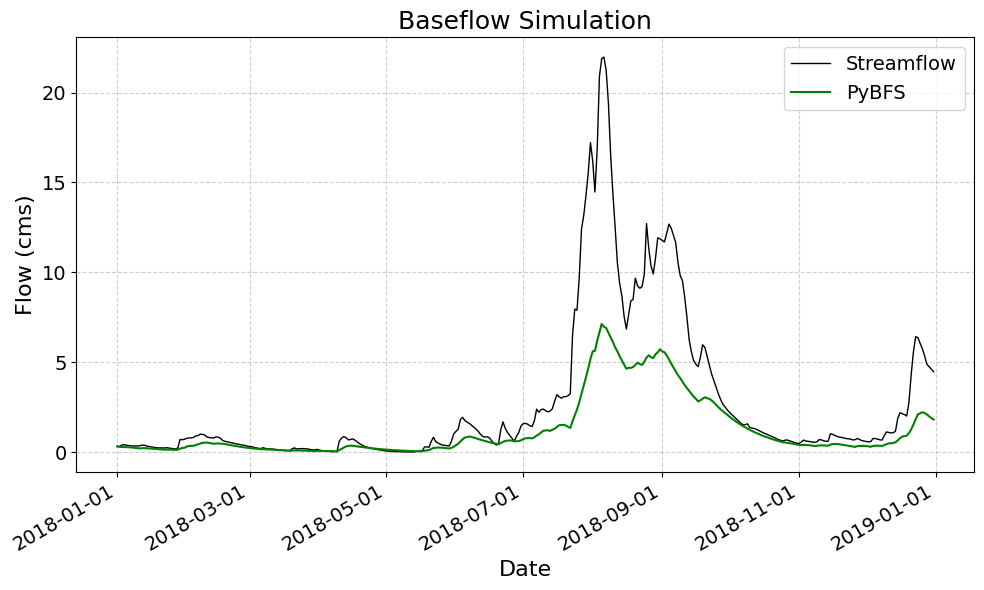

date    streamflow       baseflow
0   2018-01-01   28869.54394   27816.594060
1   2018-01-02   27156.94387   25989.319760
2   2018-01-03   34252.00128   25467.992575
3   2018-01-04   36453.91565   25092.845465
4   2018-01-05   33762.68698   24842.349130
..         ...           ...            ...
360 2018-12-27  462402.01730  188563.357115
361 2018-12-28  423256.87300  181217.331745
362 2018-12-29  411024.01540  172435.932100
363 2018-12-30  398791.15780  164080.060075
364 2018-12-31  386558.30020  156927.825945

[365 rows x 3 columns]

In [ ]:
plot_baseflow_simulation(streamflow_data, result)

# **Forecast**

Run PyBFS from January to September and Forecast from October to Decemeber

In [ ]:
# Define the start and end dates for filtering
start_date = '2018-01-01'
end_date = '2018-09-30'

# Ensure the 'Date' column is in datetime format
streamflow_data['Date'] = pd.to_datetime(streamflow_data['Date'])

# Filter the DataFrame based on the date range
streamflow_data_filtered = streamflow_data[
    (streamflow_data['Date'] >= start_date) & (streamflow_data['Date'] <= end_date)
]

In [ ]:
tmp2 = PyBFS(streamflow_data_filtered, SBT, basin_char, gw_hyd, flow)
tmp2

Date           Qob           Qsim  SurfaceFlow       Baseflow  \
0   2018-01-01   28869.54394            NaN     0.000000   27816.594060   
1   2018-01-02   27156.94387   25989.319760     0.000000   25989.319760   
2   2018-01-03   34252.00128   30960.544117  5462.068013   25467.992575   
3   2018-01-04   36453.91565   33077.320393  7882.901613   25092.845465   
4   2018-01-05   33762.68698   32645.890642  7690.631394   24842.349130   
..         ...           ...            ...          ...            ...   
268 2018-09-26  281355.72480  217089.436172   389.493287  216699.942885   
269 2018-09-27  254443.43810  206338.183958   139.051253  206199.132705   
270 2018-09-28  231201.00860  197260.481152    49.548917  197210.932235   
271 2018-09-29  217989.52240  188580.987052    17.629937  188563.357115   
272 2018-09-30  203799.40760  179432.246621     6.261641  179425.984980   

     DirectRunoff          X           Eta         StSur        StBase  \
0             NaN   32.94165           NaN      0.000000  3.878935e+05   
1        0.000000   30.57647   1167.624110      0.000000  3.619041e+05   
2       30.483529   29.82644   3291.457163  12064.956770  3.540412e+05   
3      101.573315   29.82644   3376.595257  21188.795513  3.543571e+05   
4      112.910118   29.82644   1116.796338  23663.470370  3.543037e+05   
..            ...        ...           ...           ...           ...   
268      0.000000  436.00086  64266.288628    897.752525  3.939551e+06   
269      0.000000  414.87320  48105.254142    319.907849  3.733791e+06   
270      0.000000  389.89748  33940.527448    113.826843  3.536736e+06   
271      0.000000  366.42532  29408.535348     40.428090  3.348229e+06   
272      0.000000  344.36620  24367.160979     14.334509  3.168823e+06   

     Impulse.L      Zs.L     Zb.L         Infil          Rech  RecessCount.T  \
0          NaN  0.000000  0.31517           NaN      0.000000              1   
1     0.000000  0.000000  0.29473      0.000000      0.000000              2   
2     0.004317  0.009862  0.28821  35132.071584  17605.046801              0   
3     0.005217  0.017325  0.28821  42415.473831  25408.733474              0   
4     0.004299  0.019351  0.28821  34954.300575  24788.994323              1   
..         ...       ...      ...           ...           ...            ...   
268   0.000000  0.000734  3.22187      0.000000   1227.282487              7   
269   0.000000  0.000261  3.08101      0.000000    438.793424              8   
270   0.000000  0.000093  2.91357      0.000000    156.532088              9   
271   0.000000  0.000033  2.75522      0.000000     55.768817             10   
272   0.000000  0.000012  2.60548      0.000000     19.831940             11   

     AdjPctEr    Weight  
0         NaN  0.059550  
1   -0.042957  0.115553  
2   -0.096027  0.000000  
3   -0.092564  0.000000  
4   -0.033054  0.059550  
..        ...       ...  
268 -0.228397  0.349344  
269 -0.189043  0.388090  
270 -0.146785  0.424529  
271 -0.134893  0.458798  
272 -0.119550  0.491026  

[273 rows x 18 columns]

In [ ]:
#Selects the last row values
Xi, Zbi, Zsi, StBi, StSi, Surflow, Baseflow, Rech = tmp2.iloc[-1][['X', 'Zb.L', 'Zs.L', 'StBase', 'StSur', 'SurfaceFlow', 'Baseflow', 'Rech']]

In [ ]:
ini = Xi, Zbi, Zsi, StBi, StSi, Surflow, Baseflow, Rech

For forecast, use the intial variables at the end of September to begin forecast for October to December.

In [ ]:
# Create date range
dates = pd.date_range(start="2018-10-01", end="2018-11-30", freq="D")

# Create DataFrame with NaN streamflow
df = pd.DataFrame({
    "date": dates,
    "streamflow": np.nan
})

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

In [ ]:
def forecast(streamflow, SBT, basin_char, gw_hyd, flow, initial):
  """
  Forecast step of PyBFS using provided initial states and parameters.
    - Assumes helper functions sur_q, sur_store, sur_z, recharge, infiltration exist in scope.
    - Produces a DataFrame with forecasted baseflow and states; observed Q is NaN by design.

    Parameters
    ----------
    streamflow_data : pd.DataFrame
        Must contain 'Date' and 'Streamflow' columns.
    basin_char : dict
        Expected keys: lb, x1, wb, alpha, beta, por, ws, area.
    gw_hyd : dict
        Expected keys: ks, kb, kz, rs, rb1, rb2.
    flow : dict
        Initial states/flows for t0:
        Expected keys: Xi, Zbi, Zsi, StBi, StSi, Surflow, Baseflow, Rech.
    initial : tuple
        Expected values: Xi, Zbi, Zsi, StBi, StSi, Surflow, Baseflow, Rech.

    Returns
    -------
    start_date, end_date : str or None
        Optional filter bounds in 'YYYY-MM-DD' format.

    Returns
    -------
    tmp : pd.DataFrame
        Columns: ['Date','Qob.L3','Baseflow.L3','StSur.L3','StBase.L3',
                  'Zs.L','Zb.L','Impulse.L','Infil.L3','Rech.L3']
                  """

  date = pd.to_datetime(streamflow["date"])
  qin = np.full(len(np.array(streamflow['streamflow'])), np.nan)
  p = len(qin)
    # Output variables
  X = np.full(p, np.nan)  #LONGITUDINAL LOCATION OF BASE WATER LEVEL INTERSECTION WITH SURFACE, xb
  qcomp = np.full((p, 3), np.nan) ##THREE FLOW COMPONENTS: surface flow; base flow; direct runoff from saturated areas
  ETA = np.full(p, np.nan)  ##STATE DISTURBANCES (POSITIVE VALUES REPRESENT INPUTS) [L3]
  I = np.full(p, np.nan) #PRECIPITATION CALCULATED FROM eta
  Z = np.full((p, 2), np.nan) #WATER SURFACE ELEVATION OF SURFACE (CHANNEL IS DATUM) AND BASE (BASIN OUTLET IS DATUM), ZS and Zb
  ST = np.full((p, 2), np.nan) #STORAGE, surface and base
  EXC = np.full((p, 2), np.nan) #EXCHANGES, INFILTRATION AND RECHARGE# Initialize Variables

  initial = Xi, Zbi, Zsi, StBi, StSi, Surflow, Baseflow, Rech

  ts=0
  ts_ini = True

  while ts < p:
      if ts_ini:
          xb_in = Xi
          zb_in = Zbi
          sb_in = StBi

          idx = (SBT["Xb"] <= xb_in).sum()
          qb_in = SBT["Q"].iloc[idx - 1] if idx > 0 else np.nan

          zs_in = Zsi
          ss_in = StSi
          qs_in = sur_q(lb, alpha, ks, zs_in)

                              # Storage Capacity Available
          ssa = sur_store(lb, alpha, ws, por, ws * alpha) - ss_in
          sba = max(SBT['S']) - sb_in  # Base Zone
          rech_in = min(recharge(lb, xb_in, ws, kz, zs_in, por), sba + qb_in)  # Initial Recharge Limited to Available Base Storage Capacity + Base Flow
          infil_in = 0

      # Initialize Time Step Using State Variables for Previous Time Step if Available
      if not ts_ini:
          xb_in = X[ts - 1]
          zb_in = Z[ts - 1, 1]
          sb_in = ST[ts - 1, 1]

          idx = (SBT["Xb"] <= xb_in).sum()
          qb_in = SBT["Q"].iloc[idx - 1] if idx > 0 else np.nan

          zs_in = Z[ts - 1, 0]
          ss_in = ST[ts - 1, 0]
          qs_in = sur_q(lb, alpha, ks, zs_in)

                              # Storage Capacity Available
          ssa = sur_store(lb, alpha, ws, por, ws * alpha) - ss_in
          sba = max(SBT['S']) - sb_in  # Base Zone
          rech_in = min(recharge(lb, xb_in, ws, kz, zs_in, por), sba + qb_in)  # Initial Recharge Limited to Available Base Storage Capacity + Base Flow
          infil_in = 0


      I[ts] = 0
      # End of Time Step Calculations
      ss_en = max(ss_in + infil_in - rech_in - qs_in, 0)
      zs_en = sur_z(lb, alpha, ws, por, ss_en)
      qs_en = sur_q(lb, alpha, ks, zs_en)

      infil_en = min(infiltration(lb, ws, ks, alpha, zs_en, I[ts]), ssa)
      rech_en = min(recharge(lb, xb_in, ws, kz, zs_en, por), sba + qb_in)
      sb_en = max(sb_in + rech_en - qb_in, 0)
      idx = max((SBT["S"] < sb_en).sum(), 1) - 1

      # Safely extract the values from the DataFrame
      xb_en = SBT["Xb"].iloc[idx] if 0 <= idx < len(SBT) else np.nan
      zb_en = SBT["Z"].iloc[idx] if 0 <= idx < len(SBT) else np.nan
      qb_en = SBT["Q"].iloc[idx] if 0 <= idx < len(SBT) else np.nan

          # Final Calculations for Time Step
      if ts_ini:
        qcomp[ts, 0] = Surflow
        qcomp[ts, 1] = Baseflow
        EXC[ts, 1] = Rech

      if not ts_ini:
          qcomp[ts, 0] = (qs_in + qs_en) / 2  # Surface Flow
          qcomp[ts, 1] = (qb_in + qb_en) / 2  # Base Flow

          EXC[ts, 0] = (infil_in + infil_en) / 2
          EXC[ts, 1] = (rech_in + rech_en) / 2

      if ts_ini:
          ST[ts, 1] = StBi
          ST[ts, 0] = StSi
          Z[ts, 1] = Zbi
          Z[ts, 0] = Zsi

                          # For Time Steps When States Are Available for Previous Time Step
      if not ts_ini:
          ST[ts, 0] = max(ST[ts - 1, 0] + EXC[ts, 0] - qcomp[ts, 0] - EXC[ts, 1], 0)
          ST[ts, 0] = min(ST[ts, 0], sur_store(lb, alpha, ws, por, ws * alpha))
          Z[ts, 0] = sur_z(lb, alpha, ws, por, ST[ts, 0])

          ST[ts, 1] = max(ST[ts - 1, 1] + EXC[ts, 1] - qcomp[ts, 1], 0)
          ST[ts, 1] = min(ST[ts, 1], max(SBT['S']))

          idx = max((SBT['S'] <= ST[ts, 1]).sum(), 1) - 1  # Adjust for 0-based indexing
          Z[ts, 1] = SBT['Z'].iloc[idx] if 0 <= idx < len(SBT) else np.nan

      #ETA[ts] = qin[ts] - np.sum(qcomp[ts, 0:3])  # Streamflow Residual
      idx = max((SBT['S'] <= ST[ts, 1]).sum(), 1) - 1  # Adjust for 0-based indexing
      X[ts] = SBT['Xb'].iloc[idx] if 0 <= idx < len(SBT) else np.nan
      ts += 1
      ts_ini = False
      #CLOSE CONDITION ts<p

  # OUTPUT
  tmp = pd.DataFrame({'Date': date, 'Baseflow': qcomp[:, 1],  'StSur': ST[:, 0], 'StBase': ST[:, 1], 'Zs': Z[:, 0], 'Zb': Z[:, 1], 'Rech': EXC[:, 1]})
  tmp = tmp[['Date', 'Baseflow', 'StSur', 'StBase', 'Zs', 'Zb', 'Rech']]
  return tmp


In [ ]:
f = forecast(df, SBT, basin_char, gw_hyd, flow, ini)
f

Date       Baseflow         StSur        StBase            Zs  \
0  2018-10-01  179425.984980  1.433451e+01  3.168823e+06  1.171194e-05   
1  2018-10-02  170731.390120  5.074411e+00  2.998098e+06  4.146020e-06   
2  2018-10-03  162458.116510  1.793627e+00  2.835643e+06  1.465473e-06   
3  2018-10-04  153840.673705  6.330832e-01  2.681803e+06  5.172572e-07   
4  2018-10-05  146385.887650  2.231557e-01  2.535417e+06  1.823281e-07   
..        ...            ...           ...           ...           ...   
56 2018-11-26    6437.131595  3.382083e-10  7.489847e+04  0.000000e+00   
57 2018-11-27    5976.057525  3.382083e-10  6.892241e+04  0.000000e+00   
58 2018-11-28    5545.957025  3.382083e-10  6.337645e+04  0.000000e+00   
59 2018-11-29    5148.715345  3.382083e-10  5.822774e+04  0.000000e+00   
60 2018-11-30    4755.363735  3.382083e-10  5.347237e+04  0.000000e+00   

         Zb       Rech  
0   2.60548  19.831940  
1   2.46388   7.039923  
2   2.32998   2.494843  
3   2.20335   0.882741  
4   2.08360   0.311874  
..      ...        ...  
56  0.06096   0.000000  
57  0.05575   0.000000  
58  0.05155   0.000000  
59  0.04714   0.000000  
60  0.04360   0.000000  

[61 rows x 7 columns]

Plot baseflow forecast

In [ ]:
def plot_forcast_baseflow(forecast):
  fig, axs = plt.subplots(figsize=(9, 5))
  # Plot lines
  #axs.plot(df2['date'],streamflow_list/86400, color='blue', label='USGS Streamflow',linewidth=1.5)
  date = pd.to_datetime(forecast["Date"])
  axs.plot(date,forecast['Baseflow']/86400, color='green', label='PyBFS Baseflow',linewidth=1.5)

  # Add legend
  axs.legend(loc='upper right', fontsize=13)

  # Set title and axis labels
  axs.set_title(f"Baseflow Forecast", fontsize=18)
  axs.set_xlabel('Date', fontsize=16)
  axs.set_ylabel('Flow (cms)', fontsize=16)

  axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  fig.autofmt_xdate()

  # Reduce x-tick label font size
  for label in axs.get_xticklabels():
    label.set_fontsize(1)

                      # Tick label font sizes
  axs.tick_params(axis='x', labelsize=14)
  axs.tick_params(axis='y', labelsize=14)

  plt.show()

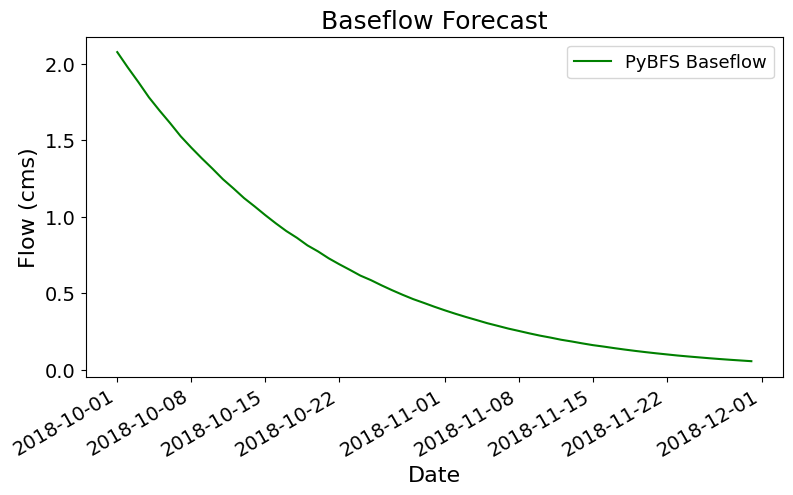

In [ ]:
plot_forcast_baseflow(f)

Plot with streamflow data

In [ ]:
# Define the start and end dates for filtering
start_date = '2018-10-01'
end_date = '2018-11-30'

# Ensure the 'Date' column is in datetime format
streamflow_data['Date'] = pd.to_datetime(streamflow_data['Date'])

# Filter the DataFrame based on the date range
streamflow_data_forecast = streamflow_data[
    (streamflow_data['Date'] >= start_date) & (streamflow_data['Date'] <= end_date)
]

In [ ]:
def plot_forecast_baseflow_streamflow(forecast_data, streamflow):

  fig, axs = plt.subplots(figsize=(9, 5))
  date = pd.to_datetime(forecast_data["Date"])

  axs.plot(date,streamflow['Streamflow']/86400, color='blue', label='USGS Streamflow',linewidth=1.5)
  axs.plot(date,forecast_data['Baseflow']/86400, color='green', label='PyBFS Baseflow',linewidth=1.5)
   # Add legend
  axs.legend(loc='upper right', fontsize=13)

  # Set title and axis labels
  axs.set_title(f"Baseflow Forecast", fontsize=18)
  axs.set_xlabel('Date', fontsize=16)
  axs.set_ylabel('Flow (cms)', fontsize=16)

  axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  fig.autofmt_xdate()

  # Reduce x-tick label font size
  for label in axs.get_xticklabels():
    label.set_fontsize(1)

                      # Tick label font sizes
  axs.tick_params(axis='x', labelsize=14)
  axs.tick_params(axis='y', labelsize=14)

  plt.show()

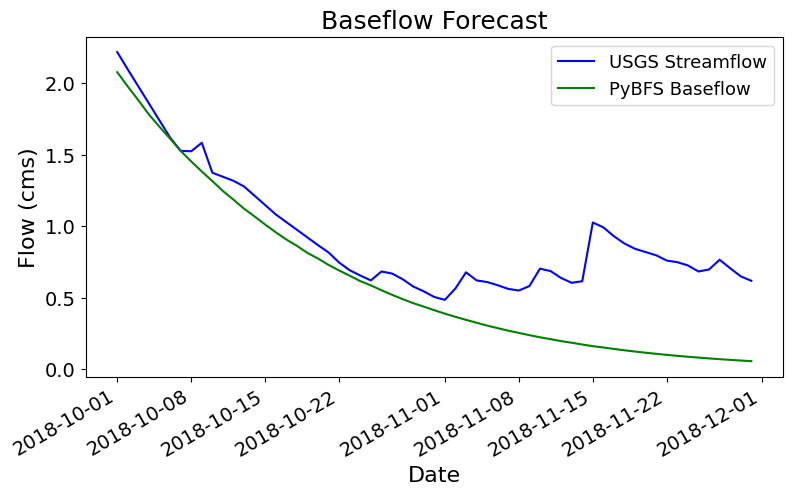

In [ ]:
plot_forecast_baseflow_streamflow(f, streamflow_data_forecast)